# <font color='orange'>Catégorisez automatiquement des questions</font>

##  <font color='navy'>Sommaire

**Partie 1 : Construction du Bag-of-words**
- <a href="#C1">Récupération des données</a>
- <a href="#C5">Nettoyage des données texte</a>
- <a href="#C10">Exploration des données</a>

# <font color='navy'>PARTIE 1 - Construction du Bag-of-words</font>

#### <font color='orange'>**Import des librairies python.**</font>

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## <a name="C1"><font color='navy'>Récupération des données</font></a>

<font color='navy'>**Dans cette partie, je réalise les étapes suivantes :**</font>
- <a href="#C2">Execution de la requête.</a>
- <a href="#C3">Scraping des résultats une fois la requête executée.</a>
- <a href="#C4">Respect du RGPD.</a>

<a name="C2"><font color='chocolate'>**Execution de la requête.**</font></a>

*<font color='green'><span style="text-decoration: underline;">Consigne</span> : Stack Overflow propose un outil d’export de données à l’aide de requêtes SQL, "StackExchange Data Explorer", qui permet de collecter des données authentiques de la plateforme d’entraide. Tu pourras donc réaliser une extraction de 50 000 questions, le nombre limite par requête.*</font>

*<font color='green'>D’autre part, fait attention, la qualité des questions et du remplissage des tags est très inégale, ce qui pourrait biaiser les résultats de ton modèle. Pour limiter ce risque et récupérer des résultats le plus pertinent possible, pense à faire des requêtes avec des contraintes sur certaines données, pour filtrer par exemple :*</font>

*<font color='green'>les questions les plus vues,
mises en favori ou jugées pertinentes par les internautes, 
ayant reçu une réponse, 
et ayant au moins 5 tags.*</font>

Récupération des données via  ['StackExchangeDataExplorer'](https://data.stackexchange.com/stackoverflow/query/edit/1842326) avec la requête suivante : 

-----------------------------------------------------------------------------------------------

SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount

FROM Posts 

<font color = 'blue'>-- PostTypeId = 1 correspond aux questions.

WHERE PostTypeId = 1 

<font color = 'blue'>-- Nombre de vues superieur à 10.

AND ViewCount > 10

<font color = 'blue'>-- Jugées pertinentes par les internautes avec un score superieur à 5.

AND Score > 5 

<font color = 'blue'>-- Ayant reçu une réponse.

AND AnswerCount > 0 

<font color = 'blue'>-- Ayant au moins 5 tags.</font>

AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

-----------------------------------------------------------------------------------------------

<a name="C3"><font color='chocolate'>**Scraping des résultats une fois la requête executée.**</font></a>

<span style="text-decoration: underline;">Le web scraping (ou scraping)</span> *est une technique utilisée pour extraire automatiquement des informations de sites web.*

Outils Communément Utilisés pour le Scraping :
- Requests : Une bibliothèque Python utilisée pour envoyer des requêtes HTTP.
- BeautifulSoup : Une bibliothèque Python pour analyser le code HTML et extraire des données.
- Scrapy : Un framework Python spécialisé dans le scraping de données à grande échelle.
- Selenium : Un outil permettant d'automatiser les navigateurs web, utile pour scraper des pages qui nécessitent une interaction ou un chargement dynamique du contenu.

Aprés vérification des conditions d'utilisation de Stack Overflow, il est ecrit explicitement que le scraping est inerdit : [Acceptable Use Policy - Content Scraping](https://stackoverflow.com/legal/acceptable-use-policy). 

Je vais donc importer les données en récuperant le fichier .csv qui résulte de la requête réalisée sur le site StackOverFlow.

In [176]:
# Import des données.
df = pd.read_csv('QueryResults.csv', low_memory=False)
pd.set_option('display.max_columns', df.shape[1])

df.head(5)

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,19,352,70525,0.0,23
1,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,25,176,16443,0.0,9
2,.Net XML comment into API Documentation,<p>Is there an easy way to produce MSDN-style ...,<visual-studio><xslt><documentation><sandcastl...,855,21,3499,0.0,6
3,Linux shell equivalent on IIS,<p>As a LAMP developer considering moving to a...,<windows><iis><shell><command-line><terminal>,1584,21,3511,NaN,8
4,Mechanisms for tracking DB schema changes,<p>What are the best methods for tracking and/...,<php><mysql><database><svn><migration>,1607,139,45004,0.0,20


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          50000 non-null  object 
 1   Body           50000 non-null  object 
 2   Tags           50000 non-null  object 
 3   Id             50000 non-null  int64  
 4   Score          50000 non-null  int64  
 5   ViewCount      50000 non-null  int64  
 6   FavoriteCount  43697 non-null  float64
 7   AnswerCount    50000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.1+ MB


In [180]:
# Typologie de colonnes.
df.dtypes.value_counts()

int64      4
object     3
float64    1
Name: count, dtype: int64

**Valeurs manquantes et doublons**

In [183]:
# Nombre de valeurs manquantes par colonnes.
df.isna().sum().sort_values()

Title               0
Body                0
Tags                0
Id                  0
Score               0
ViewCount           0
AnswerCount         0
FavoriteCount    6303
dtype: int64

<Axes: >

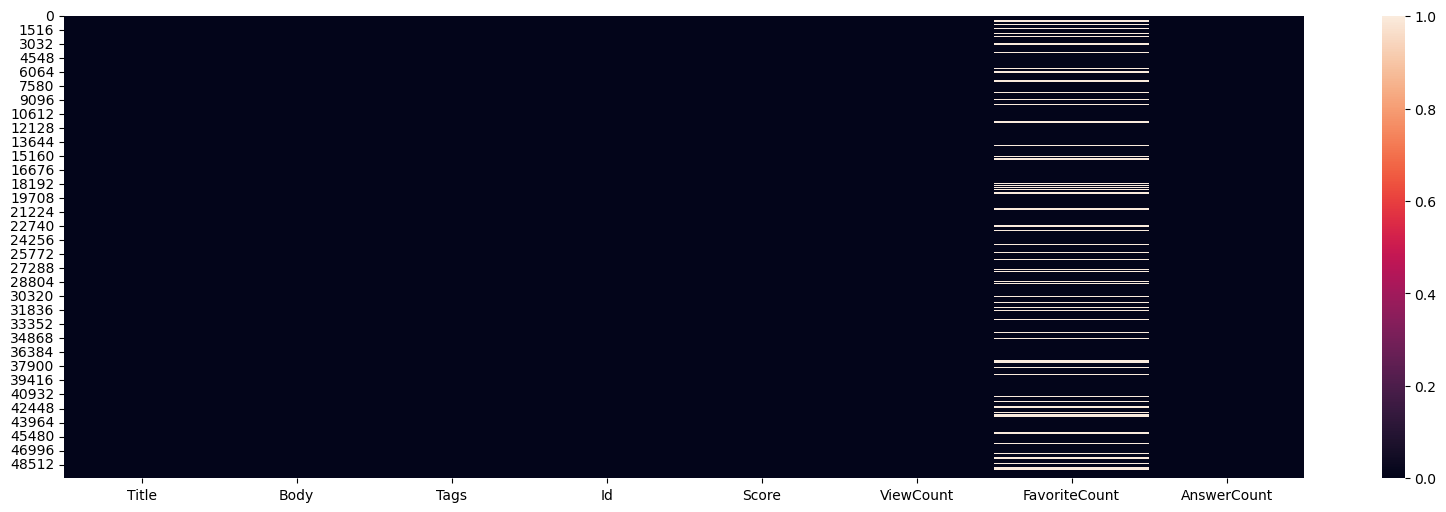

In [195]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
sns.heatmap(df.isna())

In [187]:
# Taux de valeurs manquantes pour les variables ayant des données manquantes.
nb_na = (df.isna().sum())
var_na = round((nb_na[df.isna().sum() > 0] /df.shape[0])*100,2)
var_na.sort_values(ascending=False)

FavoriteCount    12.61
dtype: float64

In [197]:
# Nombre de doublons pour une ligne entière de données.
df.duplicated().sum()

0

In [199]:
# Nombre de valeurs uniques par colonnes.
df.nunique()

Title            49999
Body             50000
Tags             49256
Id               50000
Score              844
ViewCount        28900
FavoriteCount        3
AnswerCount         67
dtype: int64

In [201]:
# Nombre de doublons par colonnes.
for col in df.columns:
    n = df.duplicated(subset=col).sum()
    print(f"{col} : {n}")

Title : 1
Body : 0
Tags : 744
Id : 0
Score : 49156
ViewCount : 21100
FavoriteCount : 49996
AnswerCount : 49933


<a name="C4"><font color='chocolate'>**Respect du RGPD.**</font></a>

[source : cnil](https://www.cnil.fr/fr/cnil-direct/question/quels-sont-les-grands-principes-des-regles-de-protection-des-donnees)

Description et application des 5 grands principes du Règlement Général sur la Protection des Données (RGPD) dans ce projet

- <span style="text-decoration: underline;">Le principe de finalité</span> : *le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime.*
 
  =>  Les données collectées sont utilisée exclusivement dans le cadre de la création d'un algorithme de machine learning qui permet d'assigner automatiquement plusieurs tags pertinents à une question. Les données ne sont pas déstinées à quelconques autres usages.

- <span style="text-decoration: underline;">Le principe de proportionnalité et de pertinence</span> : *les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier.*
  
  => On utilise des filtres sur les données de la requête pour ne récupérer que les variables essentielles au projet. On évite également de récupérer des information non necessaire qui permettrait d'identifier un individu.

- <span style="text-decoration: underline;">Le principe d'une durée de conservation limitée</span> : *il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier.*

  => Les données ne contiennent pas d'information permettant l'identification de personnes, cependant, si c'était le cas il serait necessaire de fixer une date maximale de suppression des données en accord avec les contraintes légales ou d'anonymiser les données si elles doivent être conservées plus longtemps.

- <span style="text-decoration: underline;">Le principe de sécurité et de confidentialité</span> : *le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations.*

  => Içi on ne récupère pas de <font color = 'grey'>données à caractère personnel*</font>, si ça avait été le cas, il serait necessaire d'utiliser des données fictives ou d'anonymiser les données permettant d'identifier un individu.

- <span style="text-decoration: underline;">Les droits des personnes</span> : *Le propriétaire des données doit avoir donné son accord pour que ses données personnelles soient collectées et utilisées légalement.*

  => On s'assure que les utilisateurs aient acceptés que leurs données personnelles soient collectées (par StackOverflow) grâce à l'onglet [Privacy Policy](https://stackoverflow.com/legal/privacy-policy). içi on comprends que pour créer un compte utilisateurs, il faut accpéter les conditions de collecte des données par stackoverflow.

*<font color = 'grey'>*Toute information relative à une personne physique susceptible d'être identifiée, directement ou indirectement.</font>*

## <a name="C5"><font color='navy'>Nettoyage des données texte</a></font>

## <a name="C10"><font color='navy'>Exploration des données</a></font>